In [ ]:
!pip install transformers torch elasticsearch tqdm scikit-learn

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.5/960.5 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 6.9 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/MyDrive/CS_6120_NLP/Project'
retrieval_file = f'{base_path}/output/hover_dev_bm25_top100.json'
output_file = f'{base_path}/output/hover_dev_verified_aggregated.json'

# Check file exists
import os
if os.path.exists(retrieval_file):
    print(f"✓ Found retrieval file: {retrieval_file}")
else:
    print(f"✗ File not found: {retrieval_file}")
    print("Please upload your BM25 retrieval results to Google Drive")

✓ Found retrieval file: /content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_bm25_top100.json


In [ ]:
import sys
sys.path.append(base_path)

from verify_claims_batched import verify_dataset_batched, analyze_results

✓ Batched verification code loaded!


In [ ]:
import time

#Batched version
batch_size = 32

start_time = time.time()

results = verify_dataset_batched(
    retrieval_path=retrieval_file,
    output_path=output_file,
    strategy='aggregated',  # Single strategy = fast
    batch_size=batch_size
)

elapsed = time.time() - start_time
print(f"\nTotal time: {elapsed/60:.1f} minutes")
print(f"Time per claim: {elapsed/len(results):.2f} seconds")


Multi-Hop Claim Verification (BATCHED)

Loading retrieval results from: /content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_bm25_top100.json
Loaded 4000 claims
Loading model on cuda...
Batch size: 32


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✓ Model loaded: roberta-large-mnli
Using strategy: aggregated
Batch size: 32



Verifying claims: 100%|██████████| 4000/4000 [2:20:04<00:00,  2.10s/it]



✓ Saved verification results to: /content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_verified_ensemble.json

Verification Accuracy: 2030/4000 = 50.75%


Total time: 141.3 minutes
Time per claim: 2.12 seconds


In [ ]:
#results = verify_dataset(
#    retrieval_path=retrieval_file,
#    output_path=output_file,
#    strategy='aggregated'  # Change to 'single_best', 'aggregated', or 'chain_reasoning'
#)

In [ ]:
analyze_results(output_file)


Results Analysis

Confidence Statistics:
  Mean: 0.129
  Median: 0.080
  Std: 0.148

Prediction Distribution:
  SUPPORTED: 116 (2.9%)
  NOT_SUPPORTED: 3884 (97.1%)

Accuracy by Confidence:
  [0.0, 0.3): 1814/3567 = 50.9%
  [0.3, 0.5): 143/317 = 45.1%
  [0.5, 0.7): 37/68 = 54.4%
  [0.7, 1.0): 36/48 = 75.0%


In [ ]:
import json
with open(output_file, 'r') as f:
    results = json.load(f)

# Check true distribution
true_supported = sum(1 for r in results.values() if r['true_label'] == 'SUPPORTED')
true_not_supported = sum(1 for r in results.values() if r['true_label'] == 'NOT_SUPPORTED')

print(f"TRUE DISTRIBUTION:")
print(f"  SUPPORTED: {true_supported} ({true_supported/len(results)*100:.1f}%)")
print(f"  NOT_SUPPORTED: {true_not_supported} ({true_not_supported/len(results)*100:.1f}%)")

# Calculate actual accuracy
correct = sum(1 for r in results.values() if r['predicted_label'] == r['true_label'])
print(f"\nACTUAL ACCURACY: {correct}/{len(results)} = {correct/len(results)*100:.1f}%")

TRUE DISTRIBUTION:
  SUPPORTED: 2000 (50.0%)
  NOT_SUPPORTED: 2000 (50.0%)

ACTUAL ACCURACY: 2030/4000 = 50.7%


Testing different thresholds...

Threshold    Accuracy     F1-Score     Precision    Recall       SUPPORTED   
--------------------------------------------------------------------------------
0.05         50.7         55.6         50.6         61.6         2435        
0.10         50.8         47.2         50.9         44.0         1729        
0.15         52.0         40.7         53.2         33.0         1239        
0.20         51.4         33.0         53.2         23.9         900         
0.25         51.7         27.1         55.1         18.0         653         
0.30         51.5         20.3         57.0         12.3         433         
0.35         51.2         15.1         58.2         8.7          299         
0.40         51.2         11.6         61.2         6.4          209         
0.45         50.8         8.7          60.6         4.7          155         
0.50         50.7         6.9          62.9         3.6          116         
0.55         50.6         5.

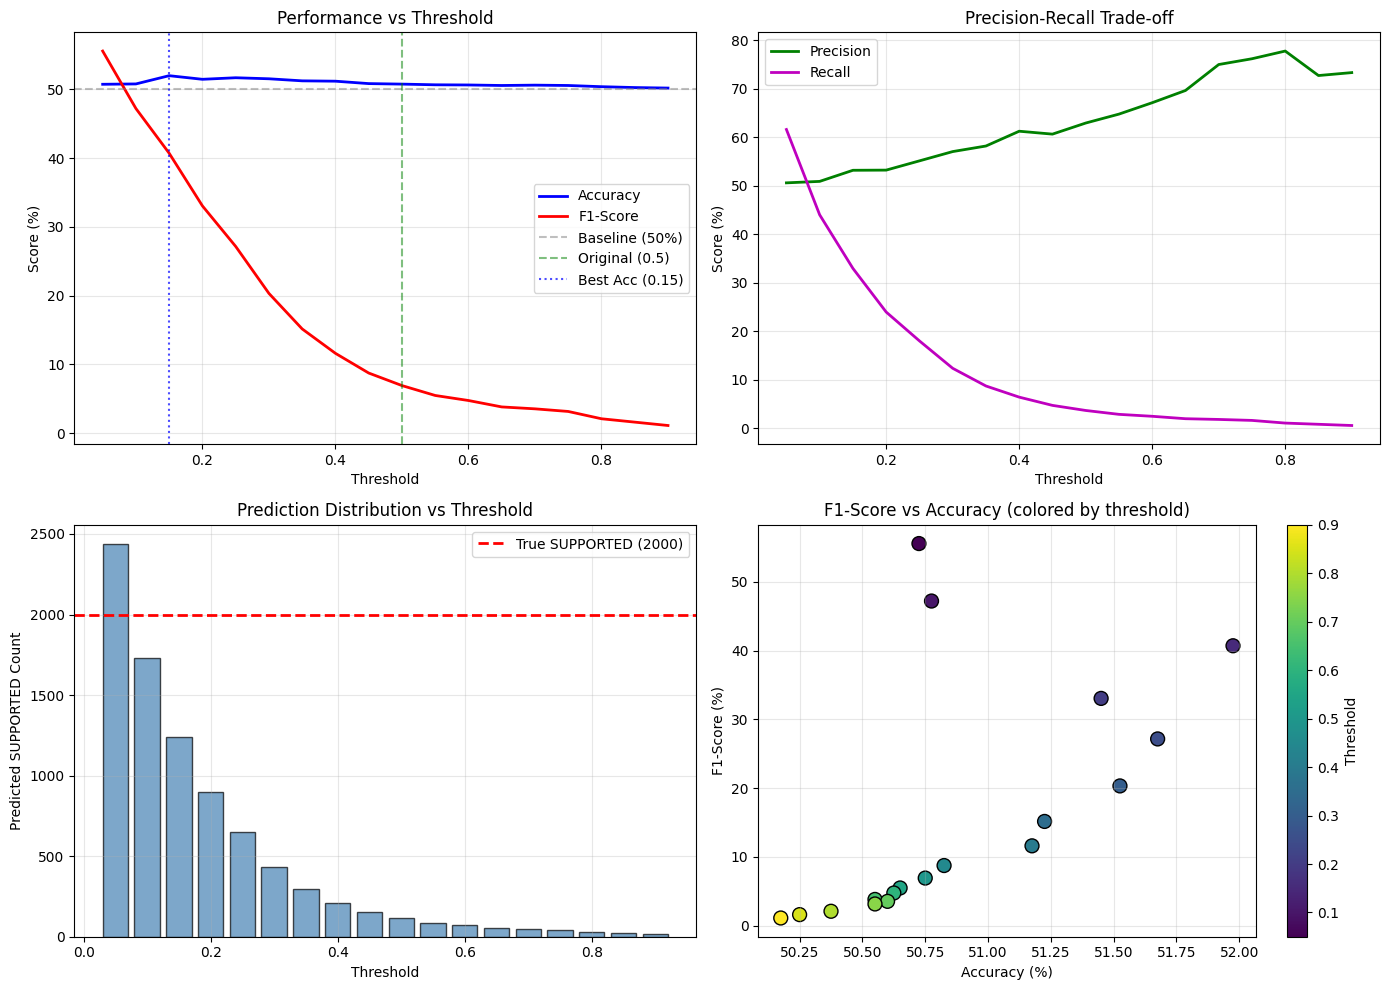


✅ Plots saved to 'threshold_optimization_comprehensive.png'


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import json

# Load your results
with open(output_file, 'r') as f:  # Your file name
    results = json.load(f)

true_labels = [r['true_label'] for r in results.values()]
confidences = [r['confidence'] for r in results.values()]

# Test many thresholds
thresholds = np.arange(0.05, 0.95, 0.05)
metrics = []

print("Testing different thresholds...\n")
print(f"{'Threshold':<12} {'Accuracy':<12} {'F1-Score':<12} {'Precision':<12} {'Recall':<12} {'SUPPORTED':<12}")
print("-" * 80)

for threshold in thresholds:
    pred_labels = ['SUPPORTED' if c > threshold else 'NOT_SUPPORTED'
                   for c in confidences]

    acc = accuracy_score(true_labels, pred_labels) * 100

    # Calculate F1, Precision, Recall for SUPPORTED class
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels,
        pos_label='SUPPORTED',
        average='binary'
    )

    sup_count = pred_labels.count('SUPPORTED')

    metrics.append({
        'threshold': threshold,
        'accuracy': acc,
        'f1': f1 * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'supported_count': sup_count
    })

    print(f"{threshold:<12.2f} {acc:<12.1f} {f1*100:<12.1f} {precision*100:<12.1f} {recall*100:<12.1f} {sup_count:<12}")

# Find best by different metrics
best_acc_idx = max(range(len(metrics)), key=lambda i: metrics[i]['accuracy'])
best_f1_idx = max(range(len(metrics)), key=lambda i: metrics[i]['f1'])

print(f"\n{'='*80}")
print("OPTIMAL THRESHOLDS:")
print(f"{'='*80}")
print(f"Best Accuracy:  threshold={metrics[best_acc_idx]['threshold']:.2f}, acc={metrics[best_acc_idx]['accuracy']:.1f}%")
print(f"Best F1-Score:  threshold={metrics[best_f1_idx]['threshold']:.2f}, f1={metrics[best_f1_idx]['f1']:.1f}%")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy and F1 vs Threshold
ax1 = axes[0, 0]
threshs = [m['threshold'] for m in metrics]
accs = [m['accuracy'] for m in metrics]
f1s = [m['f1'] for m in metrics]

ax1.plot(threshs, accs, 'b-', linewidth=2, label='Accuracy')
ax1.plot(threshs, f1s, 'r-', linewidth=2, label='F1-Score')
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Baseline (50%)')
ax1.axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='Original (0.5)')
ax1.axvline(x=metrics[best_acc_idx]['threshold'], color='blue', linestyle=':', alpha=0.7, label=f'Best Acc ({metrics[best_acc_idx]["threshold"]:.2f})')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score (%)')
ax1.set_title('Performance vs Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Precision-Recall Trade-off
ax2 = axes[0, 1]
precs = [m['precision'] for m in metrics]
recs = [m['recall'] for m in metrics]

ax2.plot(threshs, precs, 'g-', linewidth=2, label='Precision')
ax2.plot(threshs, recs, 'm-', linewidth=2, label='Recall')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score (%)')
ax2.set_title('Precision-Recall Trade-off')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Prediction Distribution
ax3 = axes[1, 0]
sup_counts = [m['supported_count'] for m in metrics]

ax3.bar(threshs, sup_counts, width=0.04, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='True SUPPORTED (2000)')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Predicted SUPPORTED Count')
ax3.set_title('Prediction Distribution vs Threshold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: F1 vs Accuracy scatter
ax4 = axes[1, 1]
scatter = ax4.scatter(accs, f1s, c=threshs, cmap='viridis', s=100, edgecolor='black')
ax4.set_xlabel('Accuracy (%)')
ax4.set_ylabel('F1-Score (%)')
ax4.set_title('F1-Score vs Accuracy (colored by threshold)')
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Threshold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Plots saved to 'threshold_optimization_comprehensive.png'")